# Complete

In [1]:
run_from = 'google_colab'
NUM_EPOCHS = 150
size = 128
train_with, mask = 'only', 'spiral_mask'
min_vote = 3
threshold = 1
patience = 5
BATCH_SIZE = 32

# Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
from tensorflow.python.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix, jaccard_score
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint



if run_from == 'google_colab':

    from google.colab import drive

    drive.mount('/content/drive')
    !mkdir /root/tensorflow_datasets
    !cp -r /content/drive/MyDrive/tensorflow_dataset/galaxy_zoo3d /root/tensorflow_datasets/.

Mounted at /content/drive


# Data

## Useful functions

In [3]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (size, size), method="nearest")
    input_mask = tf.image.resize(input_mask, (size, size), method="nearest")

    return input_image, input_mask 


def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask


def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
  
    return input_image


def binary_mask(input_mask, th):
    input_mask = tf.where(input_mask<th, tf.zeros_like(input_mask), tf.ones_like(input_mask))
    
    return input_mask


def load_image_test(datapoint):
    input_image = datapoint['image']
    input_mask = datapoint[mask]
    manga_id = datapoint['mangaid']
    input_image, input_mask = resize(input_image, input_mask)
    input_image = normalize(input_image)
    input_mask_1 = binary_mask(input_mask, th=1)
    input_mask_2 = binary_mask(input_mask, th=2)
    input_mask_3 = binary_mask(input_mask, th=3)
    input_mask_4 = binary_mask(input_mask, th=4)

    return manga_id, input_image, input_mask_1, input_mask_2, input_mask_3, input_mask_4


def display(display_list):
  plt.figure(figsize=(15, 15))
  titles = ['Image', 'Mask', 'Prediction']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.title(titles[i])
    plt.axis("off")
  plt.show()


def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

## Data loader

In [4]:
model_1 = '2022_08_26-22:05:28_only_spiral-mask_epochs:150_size:128_th:1_patience:5'
model_2 = '2022_08_25-13:16:28_all_spiral-mask_epochs:150_size:128_th:1_patience:5'
model_3 = '2022_08_16-15:53:44_only_spiral-mask_epochs:150_size:128_th:2'
model_4 = '2022_08_24-22:03:29_all_spiral-mask_epochs:150_size:128_th:2_patience:6'
model_5 = '2022_08_23-13:52:10_only_bar-mask_epochs:150_size:128_th:3_patience:5'
model_6 = '2022_08_17-13:52:32_all_spiral-mask_epochs:150_size:128_th:3_patience:10'
model_7 = '2022_08_16-14:21:51_only_spiral-mask_epochs:150_size:128_th:4'
model_8 = '2022_08_26-18:39:35_all_spiral-mask_epochs:150_size:128_th:4_patience:5'

models = [model_1, model_2, model_3, model_4,
          model_5, model_6, model_7, model_8]

In [5]:
path = '/content/drive/MyDrive/Galaxy Segmentation Project/Modelos/'

unet_models = [load_model(f'{path}{model}/{model}_best.h5') for model in models]

In [6]:
ds_test= tfds.load('galaxy_zoo3d', split=['train[75%:]'])[0]

test_batches = ds_test.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShe

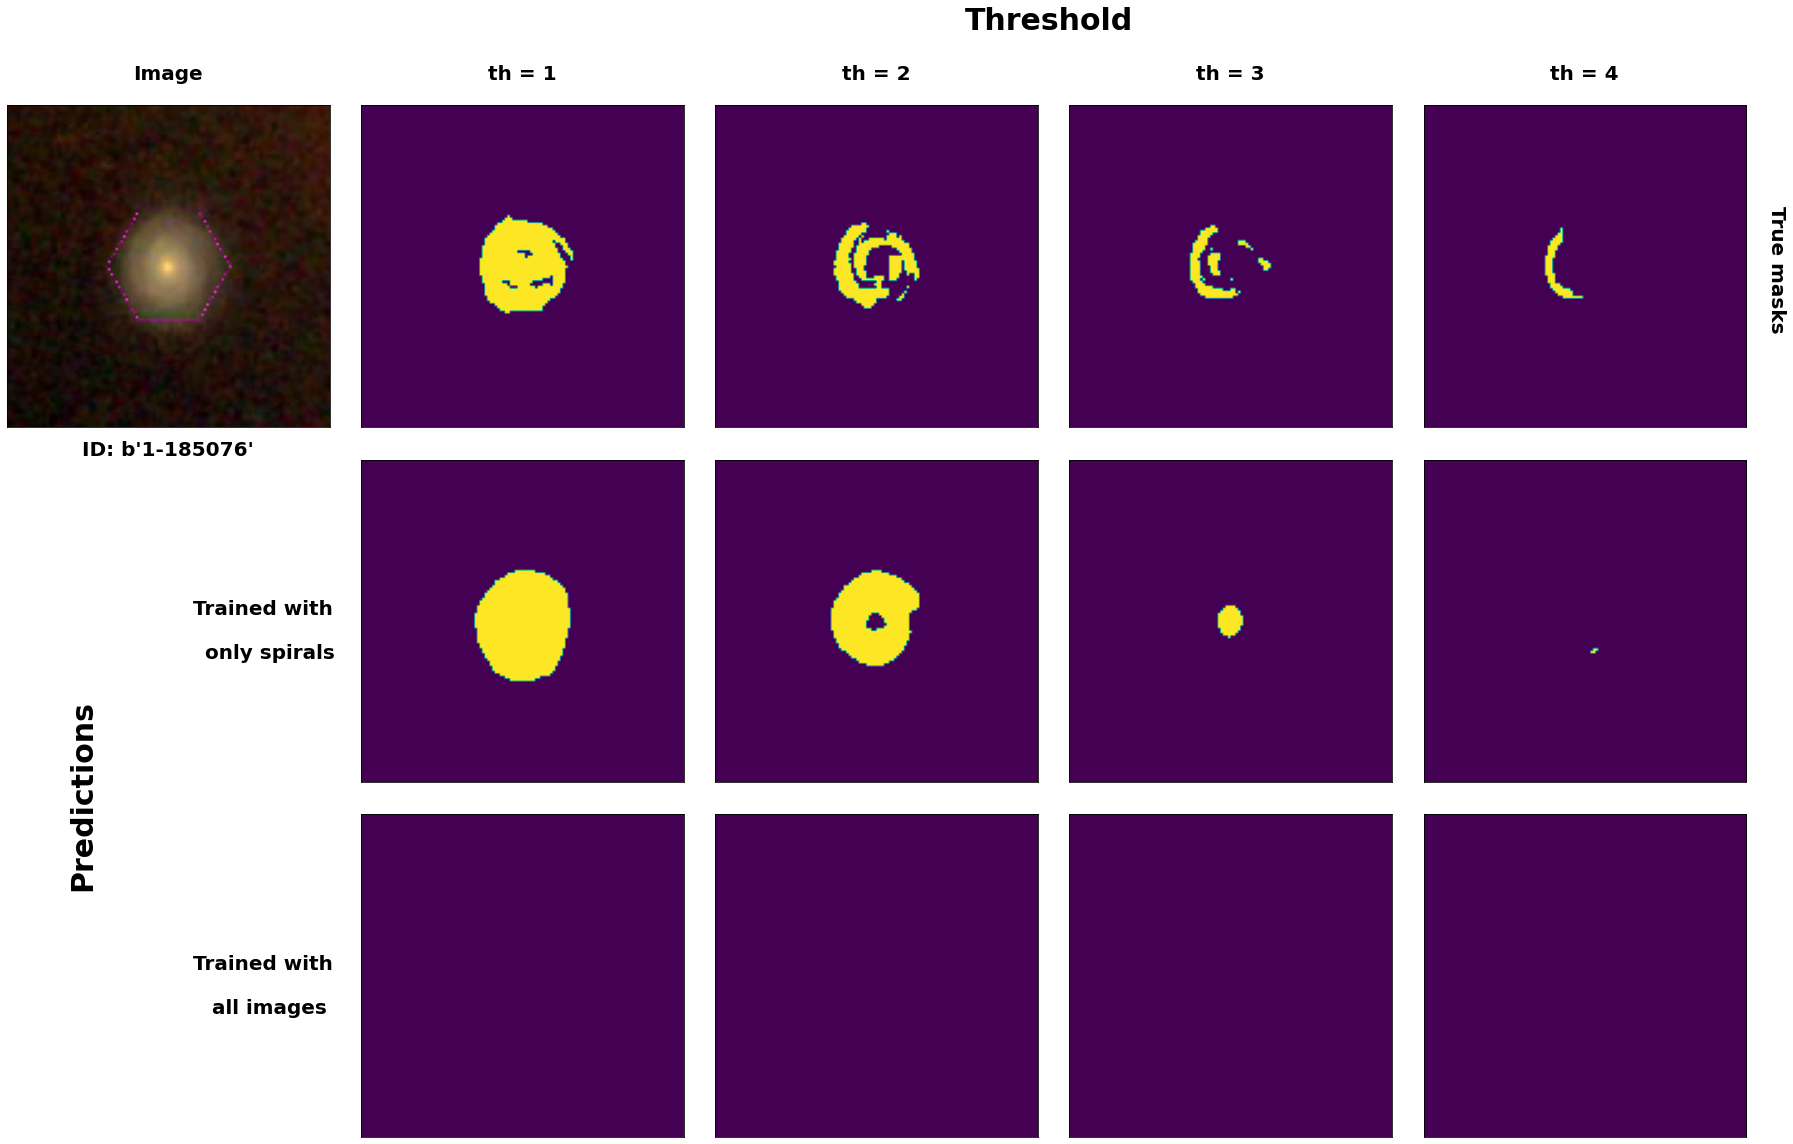

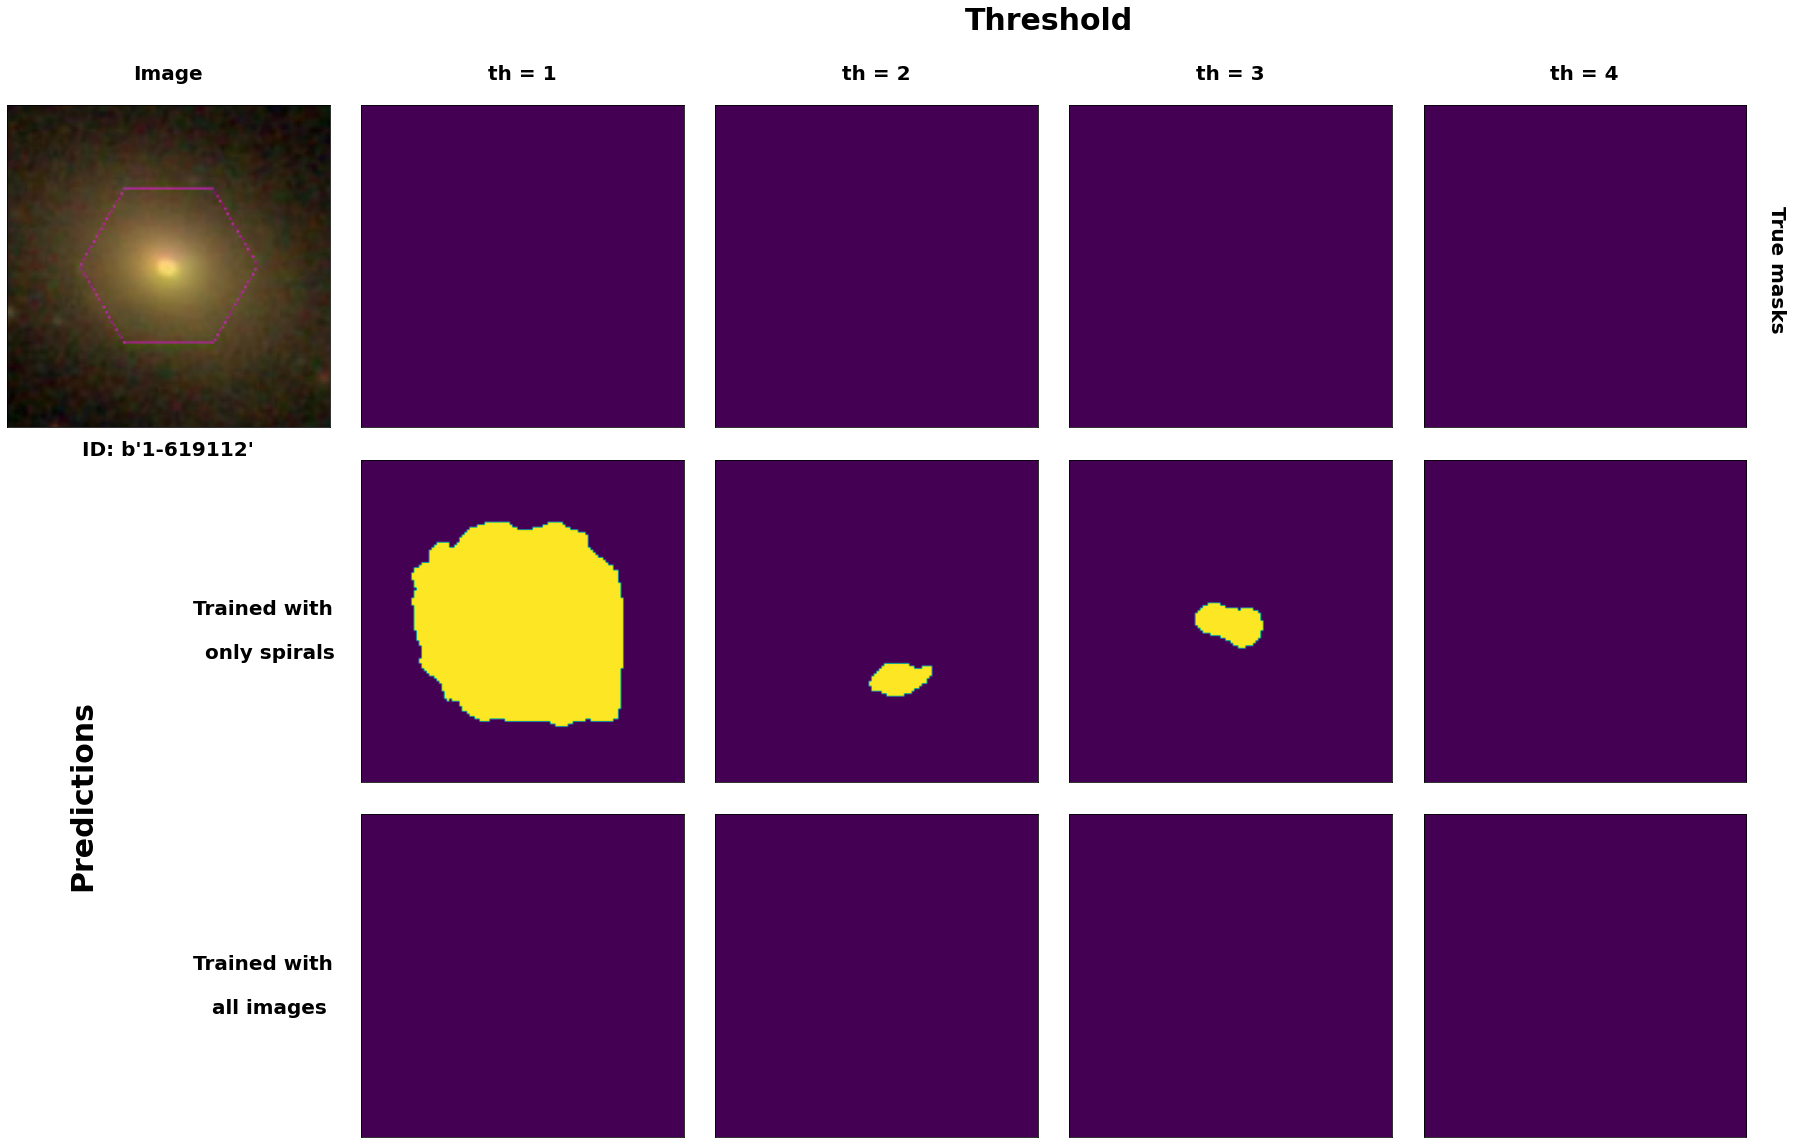

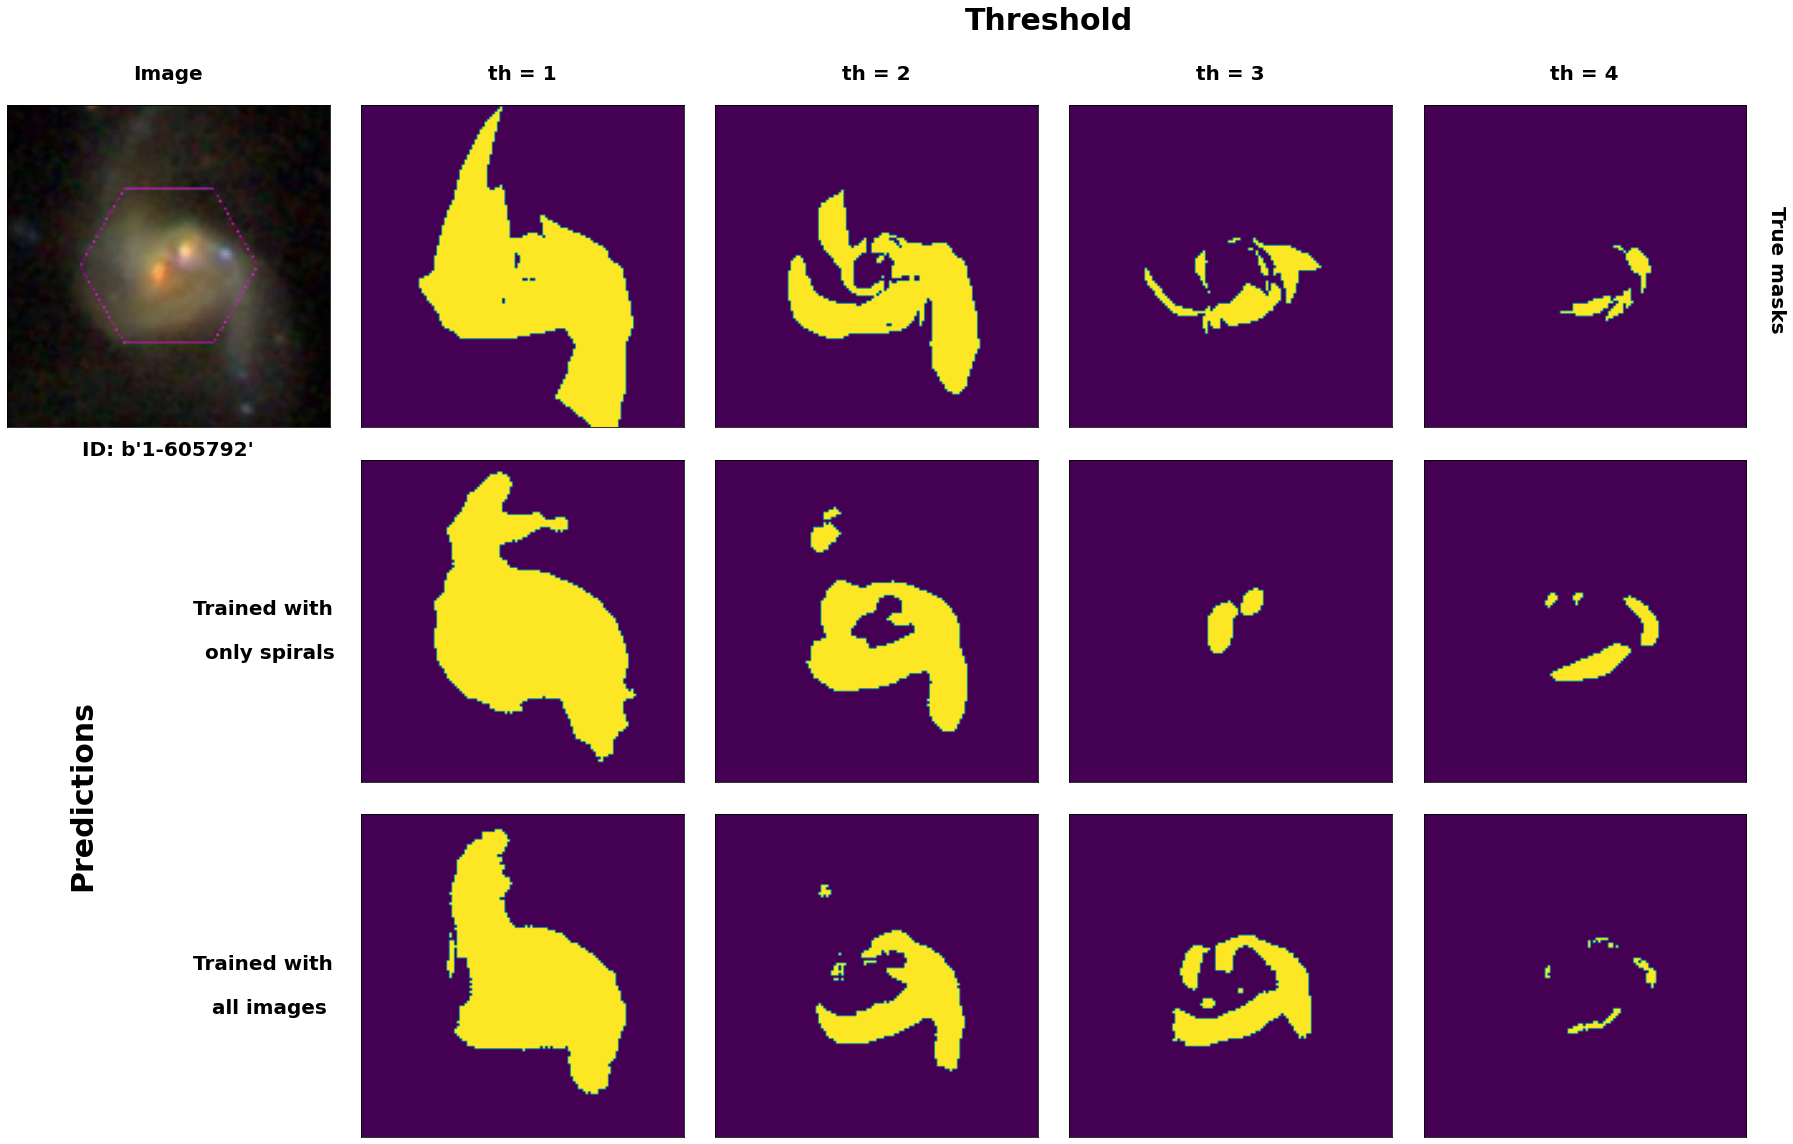

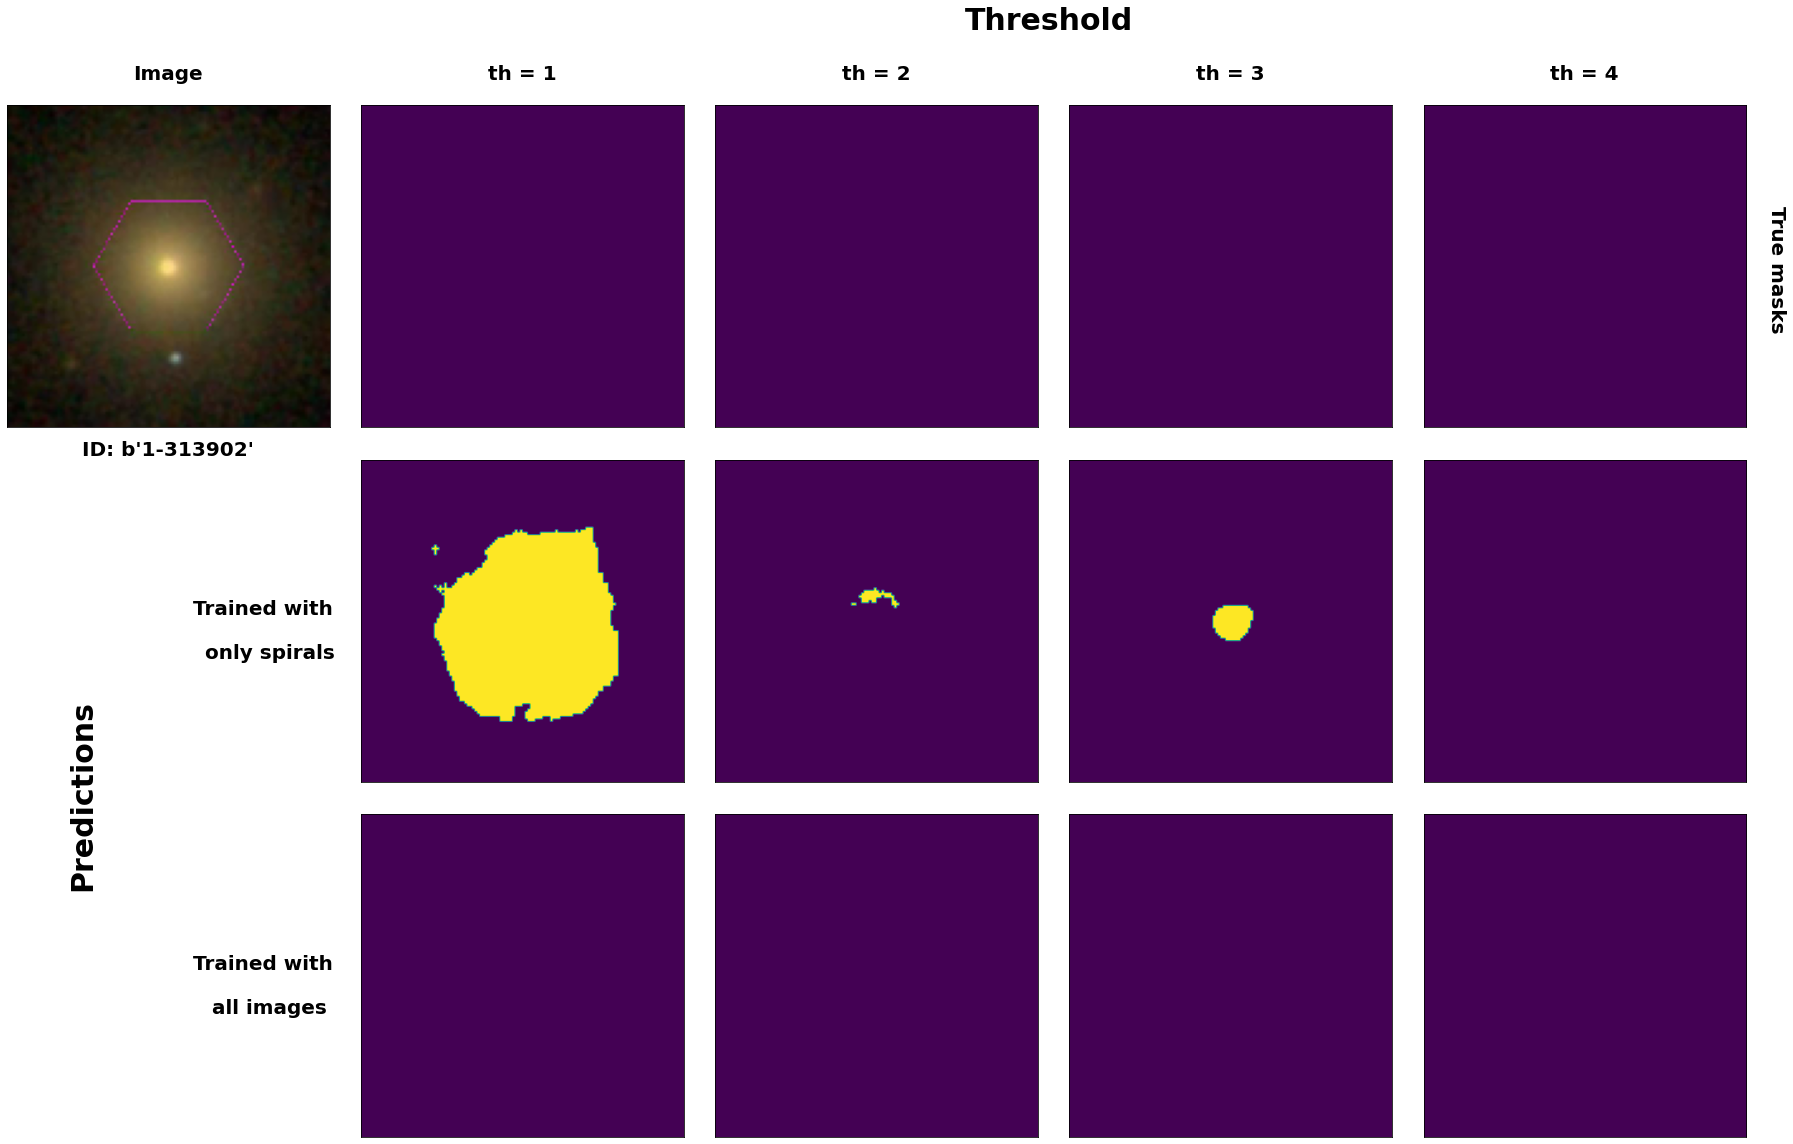

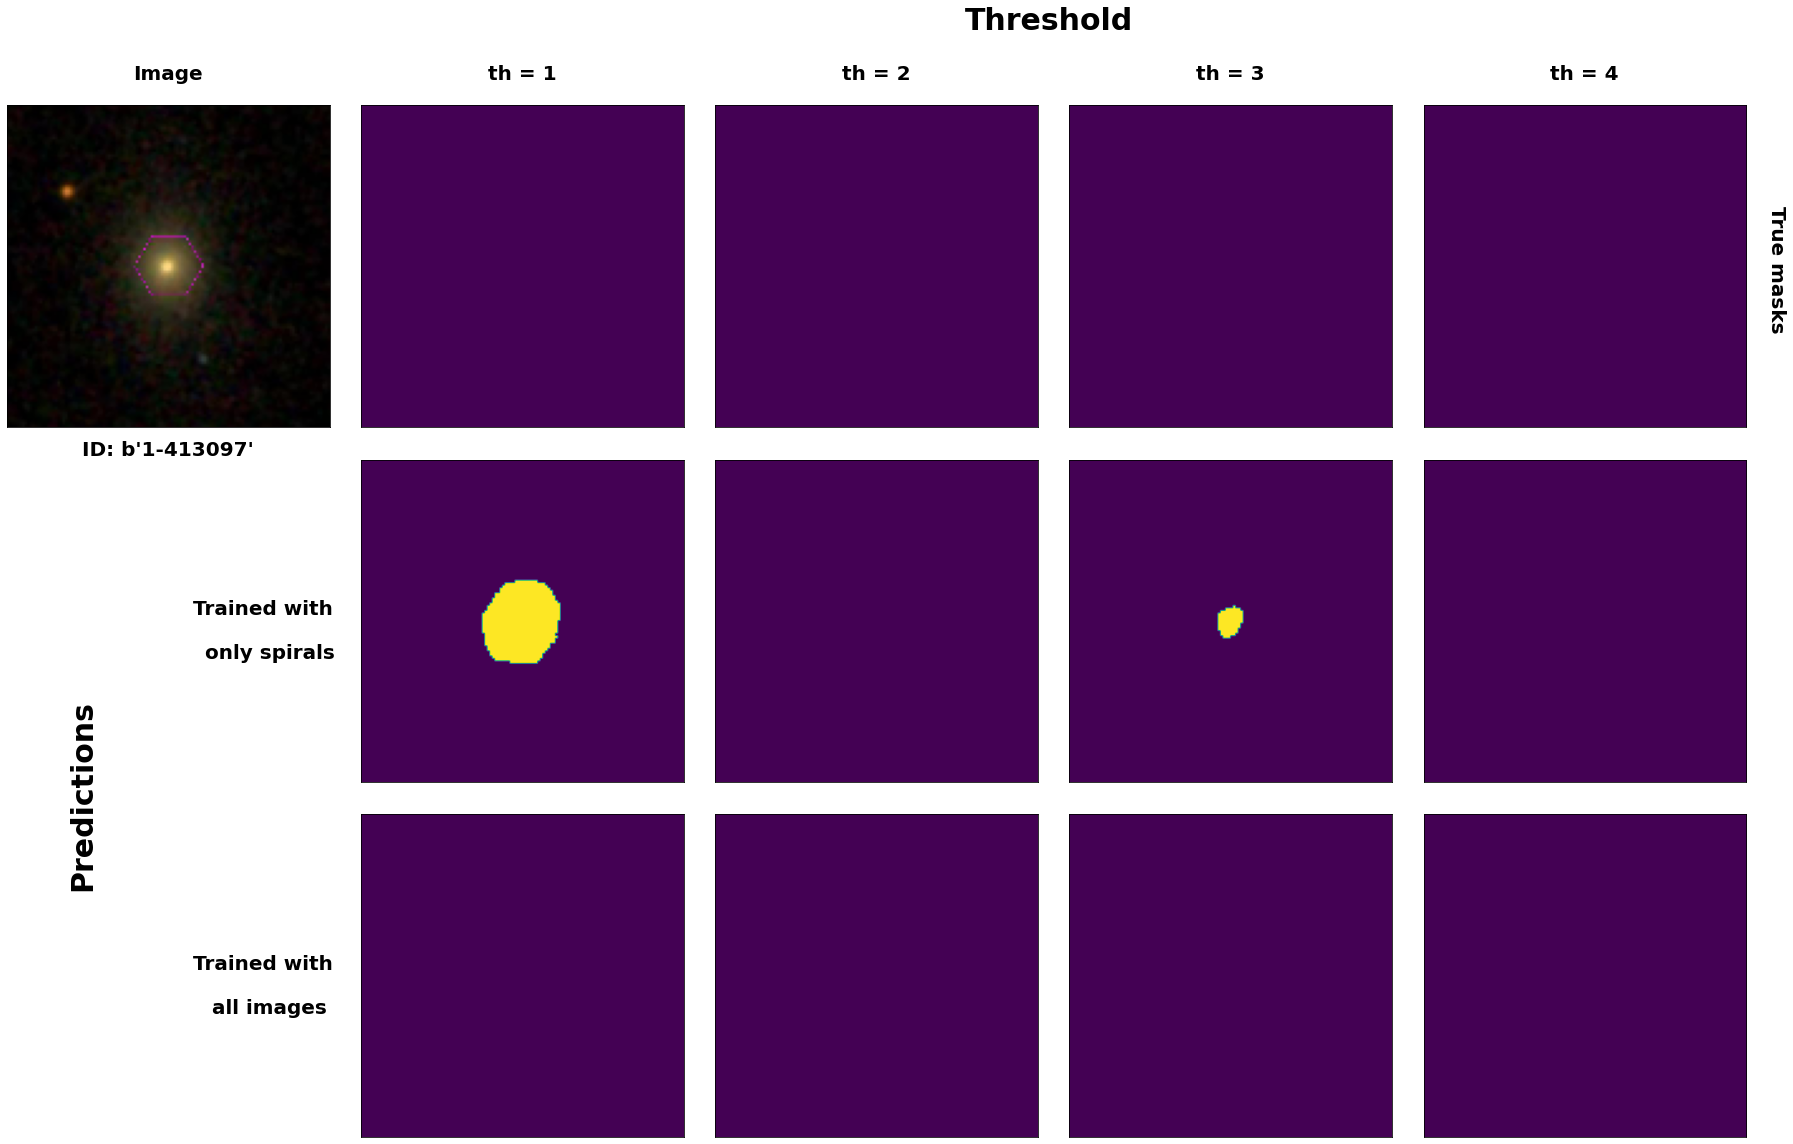

In [57]:
for gal in test_batches.take(1):

  gal_ids = [str(gal[0].numpy()[i]) for i in range(BATCH_SIZE)]

  true_masks = [gal[i] for i in range(2,6) for _ in range(2)]
  pred_masks = [create_mask(unet_model.predict(gal[1])) for unet_model in unet_models] 

  for ind in range(5):

    conf_matrices = [confusion_matrix(pred_mask[ind].numpy().reshape(-1), true_mask[ind].numpy().reshape(-1), labels=[0,1]) for pred_mask, true_mask in zip(pred_masks, true_masks)]
    
    TNs = [conf_matrix[0,0] for conf_matrix in conf_matrices]
    FNs = [conf_matrix[0,1] for conf_matrix in conf_matrices]
    FPs = [conf_matrix[1,0] for conf_matrix in conf_matrices]
    TPs = [conf_matrix[1,1] for conf_matrix in conf_matrices]

    accuracies = [(TP+TN)/(TP+TN+FP+FN) for TP, TN, FP, FN in zip(TPs, TNs, FPs, FNs)]
    precisions = [TP/(TP+FP) for TP, FP in zip(TPs, FPs)]
    sensitivities = [TP/(TP+FN) for TP, FN in zip(TPs, FNs)]
    specificities = [TN/(TN+FP) for TN, FP in zip(TNs, FPs)]
    
    jacc_scores = [jaccard_score(pred_mask[ind].numpy().reshape(-1), true_mask[ind].numpy().reshape(-1)) 
    if len(np.where(np.logical_or(pred_mask[ind].numpy().reshape(-1)==1, true_mask[ind].numpy().reshape(-1)==1))[0]) > 0 else np.nan 
    for pred_mask, true_mask in zip(pred_masks, true_masks)]


    fig, ax = plt.subplots(3, 5, figsize=(25, 15), sharey=True)
    ax[0,0].imshow(tf.keras.utils.array_to_img(gal[1][ind]))
    ax[0,0].set_title('Image', fontsize=20, fontweight='bold', pad=25)
    ax[0,0].set_xlabel('ID: '+gal_ids[ind], fontsize=20, fontweight='bold', labelpad=10)
    ax[0,1].imshow(tf.keras.utils.array_to_img(gal[2][ind]))
    ax[0,1].set_title('th = 1', fontsize=20, fontweight='bold', pad=25)
    ax[0,2].imshow(tf.keras.utils.array_to_img(gal[3][ind]))
    ax[0,2].set_title('th = 2', fontsize=20, fontweight='bold', pad=25)
    ax[0,3].imshow(tf.keras.utils.array_to_img(gal[4][ind]))
    ax[0,3].set_title('th = 3', fontsize=20, fontweight='bold', pad=25)
    ax[0,4].imshow(tf.keras.utils.array_to_img(gal[5][ind]))
    ax[0,4].set_ylabel('True masks', y=0.49, fontsize=20, fontweight='bold', labelpad=40, rotation=270)
    ax[0,4].yaxis.set_label_position("right")
    ax[0,4].set_title('th = 4', fontsize=20, fontweight='bold', pad=25)
    ax[1,1].imshow(tf.keras.utils.array_to_img(pred_masks[0][ind]))
    ax[1,1].set_ylabel('Trained with \n\n only spirals', x=0.13, y=0.37, fontsize=20, fontweight='bold', labelpad=95, rotation=0)
    ax[2,1].imshow(tf.keras.utils.array_to_img(pred_masks[1][ind]))
    ax[2,1].set_ylabel('Trained with \n\n all images', x=0.13, y=0.37, fontsize=20, fontweight='bold', labelpad=95, rotation=0)
    ax[1,2].imshow(tf.keras.utils.array_to_img(pred_masks[2][ind]))
    ax[2,2].imshow(tf.keras.utils.array_to_img(pred_masks[3][ind]))
    ax[1,3].imshow(tf.keras.utils.array_to_img(pred_masks[4][ind]))
    ax[2,3].imshow(tf.keras.utils.array_to_img(pred_masks[5][ind]))
    ax[1,4].imshow(tf.keras.utils.array_to_img(pred_masks[6][ind]))
    ax[2,4].imshow(tf.keras.utils.array_to_img(pred_masks[7][ind]))
    [axi.set_yticklabels([]) for axi in ax.ravel()]
    [axi.set_xticklabels([]) for axi in ax.ravel()]
    [axi.tick_params(axis='both', which='both',length=0) for axi in ax.ravel()]
    fig.delaxes(ax[1,0])
    fig.delaxes(ax[2,0])
    fig.suptitle('Threshold', x=0.585, y=1.05, fontsize=30, fontweight='bold')
    fig.text(0.04, 0.32, 'Predictions', va='center', rotation='vertical', fontsize=30, fontweight='bold')
    fig.savefig(f'/content/drive/MyDrive/Galaxy Segmentation Project/Binary masks figures/{gal_ids[ind]}.jpg')
    fig.tight_layout(pad=0.4, w_pad=-15, h_pad=0)

In [ ]:
count = 0
for gal in test_dataset: 
  if count < 1:
    display([gal[1]])
    count += 1
  else:
    break

In [58]:
jacc_scores

[0.0, nan, nan, nan, 0.0, nan, nan, nan]